In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import muon
import ott
import functools
import logging
import typing as t

import anndata as ad
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import scanpy as sc
import scipy.sparse as sp
import scipy.stats as ss
from ott.geometry import costs, geometry, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence
from sklearn import metrics, model_selection
from ott.geometry import costs as sparse_costs

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)

import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['default', 'despine']


In [3]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [4]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [5]:
mudata = mudata[mudata.obs["cell_type"].isin(endocrine_celltypes)]

In [6]:
def adapt_time(x):
    if x["stage"]=="E14.5":
        return 14.5
    if x["stage"]=="E15.5":
        return 15.5
    if x["stage"]=="E16.5":
        return 16.5
    raise ValueError

mudata.obs['time'] = mudata.obs.apply(adapt_time, axis=1).astype("category")
mudata = mudata[mudata.obs["time"].isin((15.5, 16.5))]

/tmp/ipykernel_3806218/3123311264.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mudata.obs['time'] = mudata.obs.apply(adapt_time, axis=1).astype("category")


In [7]:
adata=mudata["rna"]


In [8]:
adata.obs["cell_type_refined"] = mudata.obs["cell_type_refined"]
adata.obsm["X_umap"] = mudata.obsm["X_umap"]
adata.obs["time"] = mudata.obs["time"] 

/tmp/ipykernel_3806218/4083893597.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cell_type_refined"] = mudata.obs["cell_type_refined"]


In [9]:
adata.X = adata.layers["raw_counts"]

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(adata, inplace=True, subset=True)

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [12]:
gex_early = adata[adata.obs["time"]==15.5].X.A
gex_late = adata[adata.obs["time"]==16.5].X.A

In [13]:
x=gex_early
y=gex_late

In [14]:
solver = jax.jit(sinkhorn.Sinkhorn())


def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, batch_size=1)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport

In [15]:
map_l1 = entropic_map(x, y, costs.ElasticL1(scaling_reg=10.0))

In [16]:
from tqdm import tqdm
batch_size=500
push_forward = []
for i in tqdm(range(0, len(x), batch_size)):
    push_forward.append(map_l1(x[i:i+batch_size]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [20:49<00:00, 113.55s/it]


In [17]:
ls_flattened=[]
for el in push_forward:
    ls_flattened.extend(el)

In [18]:
res=np.asarray(ls_flattened)

In [19]:
gene_mask = (np.abs(res-x) > 1e-6)

In [20]:
adata_15 = adata[adata.obs["time"].isin((15.5, ))]

In [21]:
adata_15.layers["sparse_mask"] = gene_mask

/tmp/ipykernel_3806218/1174042063.py:1: ImplicitModificationWarning: Setting element `.layers['sparse_mask']` of view, initializing view as actual.
  adata_15.layers["sparse_mask"] = gene_mask


In [22]:
import os
output_dir = "/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/sparse_monge"
adata_15.write(os.path.join(output_dir, "adata_15_with_sparse_mask_10_scaling.h5ad"))

In [23]:
adata_15.var["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=0)
adata_15.obs["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=1)

In [24]:
adata_15.var["sparse_counts"].sort_values()[-5:]/len(adata_15)

Igfbpl1    0.168588
Mfap4      0.173276
Mdk        0.237546
Rpl35      0.274272
Gm10076    0.377613
Name: sparse_counts, dtype: float64

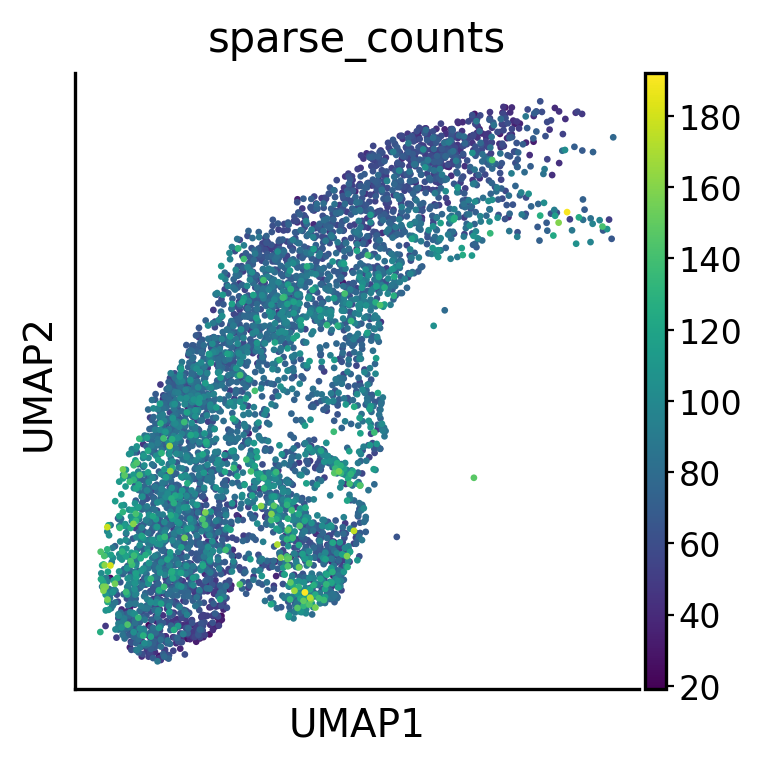

In [25]:
sc.pl.umap(adata_15, color='sparse_counts')

In [26]:
res_dict = {}
res_dict_2 = {}
for cell_type in endocrine_celltypes:
    adata_tmp = adata_15[adata_15.obs["cell_type"]==cell_type]
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    adata_tmp.obs["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=1)
    res_dict[cell_type] = adata_tmp.var["sparse_counts"].sort_values()[-5:]/len(adata_tmp)
    res_dict_2[cell_type] = (adata_tmp.var["sparse_counts"]/len(adata_tmp)).var()

/tmp/ipykernel_3806218/2226181577.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)


In [27]:
res_dict

{'Ngn3 low': Vim        0.329392
 Sparc      0.369932
 Mdk        0.385135
 Rpl35      0.606419
 Gm10076    0.645270
 Name: sparse_counts, dtype: float64,
 'Ngn3 high': Mfap4      0.338885
 Rpl35      0.362056
 Igfbpl1    0.365677
 Mdk        0.430123
 Gm10076    0.442433
 Name: sparse_counts, dtype: float64,
 'Fev+': Vim        0.250420
 Gm10076    0.272269
 Rbp4       0.280672
 Bex2       0.302521
 Ffar2      0.326050
 Name: sparse_counts, dtype: float64,
 'Fev+ Alpha': Cldn4      0.302158
 Ffar2      0.345324
 Gm10076    0.359712
 Arx        0.453237
 Pcsk2      0.460432
 Name: sparse_counts, dtype: float64,
 'Fev+ Beta': Chga       0.134931
 Mafb       0.151324
 Rpl35      0.190416
 Pdx1       0.206810
 Gm10076    0.278689
 Name: sparse_counts, dtype: float64,
 'Fev+ Delta': Isl1       0.371212
 Gm10076    0.393939
 Cck        0.416667
 Mdk        0.484848
 Cdkn1a     0.583333
 Name: sparse_counts, dtype: float64,
 'Eps. progenitors': Btbd17     0.404040
 Rpl35      0.414141
 Tmsb4

In [28]:
res_dict_2

{'Ngn3 low': 0.0016157263766625007,
 'Ngn3 high': 0.0012935649941397524,
 'Fev+': 0.0009062497103002809,
 'Fev+ Alpha': 0.00143127534378192,
 'Fev+ Beta': 0.00042194093689412385,
 'Fev+ Delta': 0.0016166644571097477,
 'Eps. progenitors': 0.0021851061675179674,
 'Alpha': 0.0005350551647950598,
 'Beta': 0.0003501520541576097,
 'Delta': 0.0009221584052218243,
 'Epsilon': 0.001928359933214778}

In [29]:
import pandas as pd
df = pd.DataFrame.from_dict(res_dict_2, orient="index")#.sort_values("score")

In [30]:

df.sort_values(0)

,0
Beta,0.000350
Fev+ Beta,0.000422
Alpha,0.000535
Fev+,0.000906
Delta,0.000922
Ngn3 high,0.001294
Fev+ Alpha,0.001431
Ngn3 low,0.001616
Fev+ Delta,0.001617
Epsilon,0.001928


In [31]:
sc.pp.pca(adata_15)
sc.pp.neighbors(adata_15, use_rep="X_pca", n_neighbors=50)

In [32]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

js = []
for i in tqdm(range(len(adata_15))):
    neighbors = (adata_15.obsp["distances"][i]>0).T
    adata_cell = adata_15[i]
    adata_tmp = adata_15[list(neighbors.A[:,0])]   
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    genes_neighborhood = adata_tmp.var["sparse_counts"][adata_tmp.var["sparse_counts"]>0].index
    genes_cell = adata_cell.var["sparse_counts"][adata_cell.var["sparse_counts"]>0].index
    js.append(jaccard_similarity(set(genes_neighborhood), set(genes_cell)))
    
    

  0%|                                                                                                              | 0/5119 [00:00<?, ?it/s]/tmp/ipykernel_3806218/1869075853.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5119/5119 [01:59<00:00, 42.83it/s]


In [33]:
adata_15.obs["js_inv"] = 1-np.asarray(js)

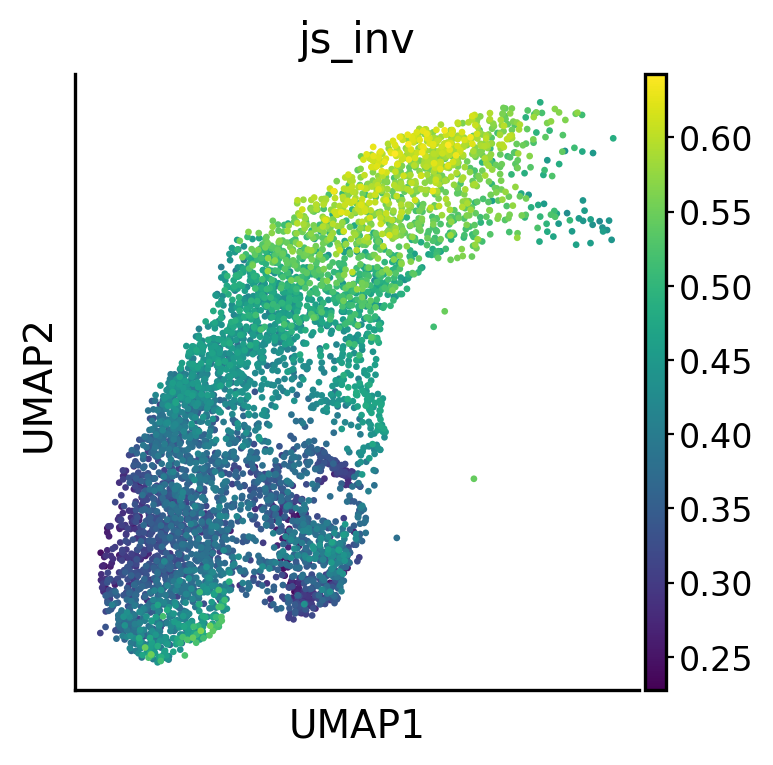

In [34]:
sc.pl.umap(adata_15, color="js_inv")

In [35]:
adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")

/tmp/ipykernel_3806218/2605882233.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")


,js_inv
cell_type_refined,
Delta,0.328553
Fev+ Beta,0.347484
Alpha,0.349279
Fev+ Alpha,0.352146
Beta,0.386553
Fev+,0.396373
Epsilon,0.414935
"Fev+ Delta,1",0.447419
"Fev+ Delta,0",0.455609
